In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from pdb import *
from pathlib import Path
from skimage.io import imread

In [2]:
from fastai.torch_basics import *
from fastai.data.all import *
from fastai.vision.all import *
# from PIL import Images

In [3]:
from nuclei import *

In [4]:
DATA_PATH =  Path('../data/datasciencebowl')
TRAIN_PATH = DATA_PATH/'stage1_train'

In [5]:
torch.cuda.set_device(1)

## Point annotations

In [6]:
pt_annotations = get_pt_annotations(DATA_PATH)

## Create gaussian mask

In [8]:

def get_x(idx):
    return TRAIN_PATH/images[idx]

def get_y(idx, r=14, sz=256):
    w,h = PILImage.create(TRAIN_PATH/images[idx]).shape
#     r = int(r * w / sz)
    mask = np.zeros((w,h))
    for x,y in points[idx]:
        draw_umich_gaussian(mask, (x,y), r)
    return PILMask.create(mask.astype(float))

In [9]:
images, points = zip(*pt_annotations)

In [10]:
idxs = range(len(images))
train_idxs = [idx for idx,image in enumerate(images) if image.stem not in set(VAL_IMAGE_IDS)]
valid_idxs = [idx for idx,image in enumerate(images) if image.stem in set(VAL_IMAGE_IDS)]

In [11]:
tfms = [[get_x, PILImage.create], [get_y]]
dsets = Datasets(items=idxs, tfms=tfms, splits=[train_idxs, valid_idxs])

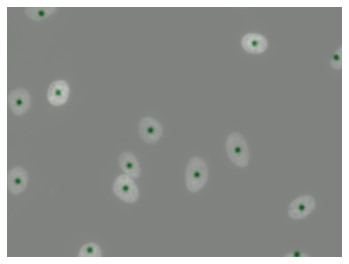

In [12]:
idx = 21
ctx = dsets[idx][0].show(figsize=(6,6))
dsets[idx][1].show(ctx=ctx, cmap='Greens', alpha = 0.5)
idx += 1

In [13]:
import matplotlib as mpl
cmap = mpl.cm.tab20
cmap.set_under('k', 0.0)

<ipython-input-13-fb3a472f6168>:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("tab20"))
  cmap.set_under('k', 0.0)


In [14]:
# currently augmentation transform screws with the padding
batch_tfms = [*aug_transforms(), Normalize.from_stats(*imagenet_stats)]

sz_mthd = RandomCrop
# sz_mthd = Resize

dls = dsets.dataloaders(bs=16, after_item=[sz_mthd(256), ToTensor, IntToFloatTensor], after_batch=batch_tfms, num_workers=8)
dls.c = 1

In [15]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([16, 3, 256, 256]), torch.Size([16, 256, 256]))

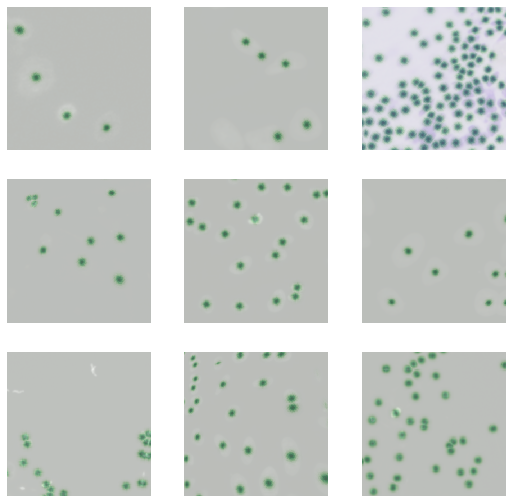

In [16]:
dls.show_batch(cmap="Greens", alpha=0.5)

## Learner

In [17]:
def acc_nuclei(input, target):
    target = target[:, None]
    target = F.interpolate(target, size=64)
    mask = target > 0.1
    acc = (input[mask] > 0.1) == (target[mask] > 0.1)
    return acc.float().mean()

In [18]:

def _neg_loss(pred, gt):
    ''' Modified focal loss. Exactly the same as CornerNet.
      Runs faster and costs a little bit more memory
    Arguments:
      pred (batch x c x h x w)
      gt_regr (batch x c x h x w)
    '''
    
    pos_inds = gt.gt(0.98).float()
    neg_inds = gt.lt(0.98).float()

    neg_weights = torch.pow(1 - gt, 4)

    loss = 0

    pos_loss = torch.log(pred) * torch.pow(1 - pred, 2) * pos_inds
    neg_loss = torch.log(1 - pred) * torch.pow(pred, 2) * neg_weights * neg_inds

    num_pos  = pos_inds.float().sum()
    pos_loss = pos_loss.sum()
    neg_loss = neg_loss.sum()

    if num_pos == 0: 
        loss = loss - neg_loss
    else:
        loss = loss - (pos_loss + neg_loss) / num_pos
    return loss

class FocalLoss(nn.Module):
    '''nn.Module warpper for focal loss'''
    def __init__(self):
        super().__init__()
        self.neg_loss = _neg_loss

    def forward(self, out, target):
        target = target.data[:, None]
        target = F.interpolate(target, size=64)
        bs = target.shape[0]
        loss = self.neg_loss(torch.sigmoid(out), target)
        return loss / bs
    
    def activation(self, x): return torch.sigmoid(x)

In [19]:
loss_func = FocalLoss()
metrics=acc_nuclei

In [20]:
import hourglass

In [21]:

heads = {
'hm': 1,
# 'reg': 2,
# 'wh': 2
}
m = hourglass.HourglassNet(heads, num_stacks=2)

In [22]:
learn = Learner(dls, m, metrics=metrics, loss_func=loss_func)
learn.path = DATA_PATH

In [23]:
learn.fit_one_cycle(60, 1e-3, wd=1e-4)

epoch,train_loss,valid_loss,acc_nuclei,time
0,0.143210,0.150724,0.000000,00:17
1,0.106230,0.141538,0.022882,00:17
2,0.095600,0.097814,0.030421,00:17
3,0.089241,0.115395,0.014812,00:17
4,0.083548,0.089874,0.028818,00:17
5,0.079658,0.099766,0.040603,00:17
6,0.081870,0.102897,0.023756,00:17
7,0.078069,0.075019,0.014856,00:17
8,0.083546,0.092913,0.002704,00:17
9,0.085227,0.102564,0.000332,00:17


In [24]:
learn.save('centernet_hourglass_104')

Path('models/centernet-256-gaussian_hourglass_104-random_crop.pth')

In [25]:
learn.load('centernet_hourglass_104')

In [26]:
learn.fit_one_cycle(60, 1e-4, wd=1e-4)

epoch,train_loss,valid_loss,acc_nuclei,time
0,0.041784,0.048902,0.031061,00:17
1,0.040975,0.049063,0.029249,00:17
2,0.040121,0.049428,0.030927,00:17
3,0.041621,0.049147,0.030283,00:17
4,0.042267,0.049041,0.030892,00:18
5,0.041637,0.049361,0.031729,00:18
6,0.041915,0.049229,0.031370,00:18
7,0.041603,0.047352,0.032297,00:18
8,0.039915,0.048305,0.031468,00:17
9,0.039866,0.048854,0.031708,00:17


In [27]:
learn.save('centernet_hourglass_104_run2')

Path('models/centernet-256-gaussian_hourglass_104-random_crop_run2.pth')

In [24]:
learn.load('centernet_hourglass_104_run2')

In [27]:
def max_px(box, targ):
    targ = targ[0]
    m = np.zeros_like(targ)
#     x,y,w,h = box
    y,x,h,w = box
    m[x:x+w,y:y+h] = 1
    ind = np.unravel_index(np.argmax(targ*m, axis=None), targ.shape)
#     if ind == (0,0): pdb.set_trace()
    return ind

def ed(pt1, pt2):
    (xA,yA), (xB,yB) = pt1, pt2
    return ((xB-xA)**2 + (yB-yA)**2)**0.5

def calc_pr_area(lbls, preds, pmaxs, min_area=1, max_dist=5, iou_thresh=0.1):
    tps = []
    fps = []
    scores = []
    n_gts = []
    for lbl,pred,pmax in zip(lbls,preds,pmaxs):
        contours,hierarchy = cv2.findContours(pmax.max(0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        pboxes = [cv2.boundingRect(cnt) for cnt in contours if cv2.contourArea(cnt) >= min_area]
        pboxes = [max_px(pbox, pred) for pbox in pboxes]
        pboxes = list(sorted(pboxes, key=lambda x: pred[0][x], reverse=True)) # sort by scores

        contours,hierarchy = cv2.findContours((lbl>=0.9).max(0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        lboxes = [max_px(cv2.boundingRect(cnt), lbl) for cnt in contours]
                
        detected = []
        dists = []
        for pb in pboxes:
            calc = [(ed(lb, pb), lb) for lb in lboxes if lb not in detected]
            if len(calc) == 0:
                dists.append(1e10)
            else:
                dist, lb = min(calc)
#                 print(dist)
                detected.append(lb)
                dists.append(dist)
        tp = (np.array(dists) <= max_dist)
        fp = ~tp
        s = np.array([pred[0, pb[0],pb[1]] for pb in pboxes])
            
        
        n_gts.append(len(lboxes))
        tps.extend(tp.astype(np.uint8).tolist())
        fps.extend(fp.astype(np.uint8).tolist())
        scores.extend(s.tolist())
        
    res = sorted(zip(scores, tps, fps), key=lambda x: x[0], reverse=True)
    res = np.array(res)
    if len(res) == 0: res = np.zeros((1, 3))
    tp = res[:,1].cumsum(0)
    fp = res[:,2].cumsum(0)
    precision = tp / (tp + fp + 1e-8)
    recall = tp / sum(n_gts)
    return precision, recall


In [28]:
preds, lbls = learn.get_preds()
preds = F.interpolate(preds, size=256)
preds = preds.detach().cpu().numpy()

lbls = lbls[:, None]
# lbls = F.interpolate(lbls, size=64)
lbls = lbls.detach().cpu().numpy()

lbls.shape, preds.shape

((67, 1, 256, 256), (67, 1, 256, 256))

In [29]:
for dist in [2, 5, 10]:
    aps = []
    for s in [1, 2, 5, 8]:
        for sz in [1,2,4]:
            score_thresh = s/10
            pmaxs = (preds >= score_thresh).astype(np.uint8)

            precision, recall = calc_pr_area(lbls, preds, pmaxs, max_dist=dist, min_area=sz)
            F1 = (2 * (precision * recall) / (precision + recall))[-1]
            aps.append((compute_ap(precision, recall),sz,score_thresh,F1))
#             aps.append((compute_ap(precision, recall),score_thresh,sz,F1))
    print(dist, max(aps))

2 (0.33235905455496867, 4, 0.2, 0.46585594012951087)
5 (0.7389213790660473, 4, 0.2, 0.8082319925138504)
10 (0.7862187526386459, 4, 0.2, 0.8537574056724235)


In [34]:
for dist in [2, 5, 10]:
    aps = []
    for s in [1, 2, 5, 8]:
        for sz in [1,2,4]:
            score_thresh = s/10
            pmaxs = (preds >= score_thresh).astype(np.uint8)

            precision, recall = calc_pr_area(lbls, preds, pmaxs, max_dist=dist, min_area=sz)
            aps.append((compute_ap(precision, recall),sz,score_thresh))
    print(dist, max(aps))

2 (0.33235905455496867, 4, 0.2)
5 (0.7389213790660473, 4, 0.2)
10 (0.7862187526386459, 4, 0.2)


In [40]:
preds, lbls = learn.get_preds()
# preds = F.interpolate(preds, size=256)
preds = preds.detach().cpu().numpy()

lbls = lbls[:, None]
lbls = F.interpolate(lbls, size=64)
lbls = lbls.detach().cpu().numpy()

lbls.shape, preds.shape

((67, 1, 64, 64), (67, 1, 64, 64))

In [42]:
for dist in [2, 5, 10]:
    aps = []
    for s in [1, 2, 5, 8]:
        for sz in [1,2,4]:
            score_thresh = s/10
            pmaxs = (preds >= score_thresh).astype(np.uint8)

            precision, recall = calc_pr_area(lbls, preds, pmaxs, max_dist=dist*2, min_area=sz)
            aps.append((compute_ap(precision, recall),sz,score_thresh))
    print(dist, max(aps))

2 (0.45134248196853555, 1, 0.1)
5 (0.5989304202999362, 1, 0.1)
10 (0.7494575542419321, 1, 0.1)


In [45]:
preds, lbls = learn.get_preds()
preds = preds.detach().cpu().numpy()
lbls = lbls[:, None].detach().cpu().numpy()

In [33]:
count_parameters(learn.model)

188881026

<AxesSubplot:>

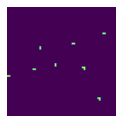

In [34]:
PILImage.create(lbls[2, 0] > score_thresh).show()

<AxesSubplot:>

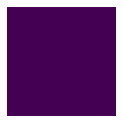

In [35]:
PILImage.create(preds[2, 0] > score_thresh).show()

In [36]:
import matplotlib as mpl
cmap = mpl.cm.Greens
# cmap = mpl.cm.Dark2
cmap.set_under('k', 0.0)
# cmap.set_bad('k', 0.0)
# mask.show(cmap=cmap, vmin=1, alpha=1.0)

<ipython-input-36-39d84c6f035d>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Greens"))
  cmap.set_under('k', 0.0)


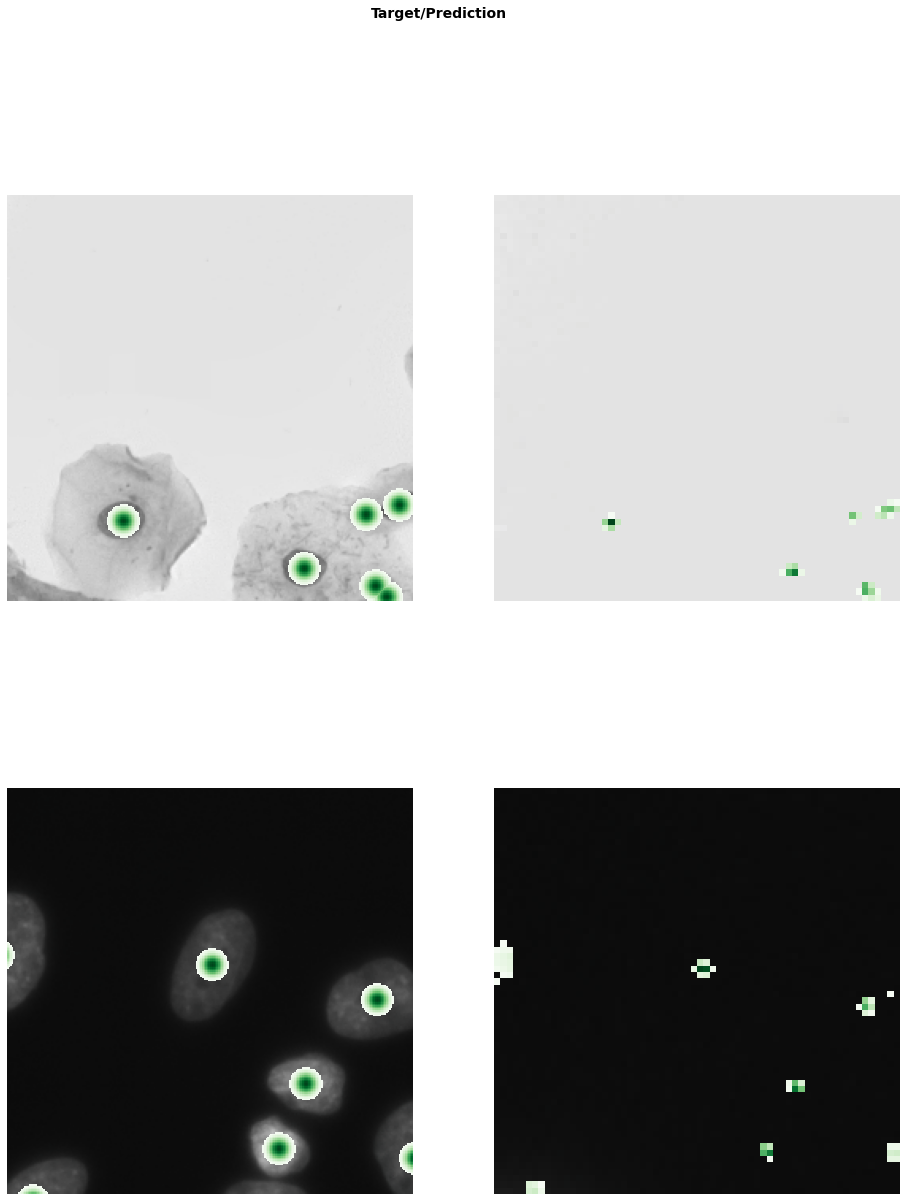

In [37]:
learn.show_results(figsize=(16,20), cmap=cmap, vmin=0.1, max_n=4, alpha=1.0, shuffle=True)